In [4]:
import random
import string

random.seed(42)

def random_typo(word, prob=0.2):
    # with probability prob, corrupt the word
    if len(word) < 3 or random.random() > prob:
        return word

    ops = ["swap", "delete", "insert"]
    op = random.choice(ops)

    chars = list(word)
    if op == "swap" and len(chars) >= 2:
        i = random.randint(0, len(chars) - 2)
        chars[i], chars[i+1] = chars[i+1], chars[i]
    elif op == "delete" and len(chars) >= 1:
        i = random.randint(0, len(chars) - 1)
        del chars[i]
    elif op == "insert":
        i = random.randint(0, len(chars))
        c = random.choice(string.ascii_lowercase)
        chars.insert(i, c)

    return "".join(chars)

def corrupt_text(text, word_prob=0.2):
    words = str(text).split()
    noisy = [random_typo(w, prob=word_prob) for w in words]
    return " ".join(noisy)

In [5]:
noise_level = 0.2  # 20% of words corrupted

train_noisy = train_df.copy()
test_noisy = test_df.copy()

train_noisy["text_noisy"] = train_noisy["description"].astype(str).apply(
    lambda t: corrupt_text(t, word_prob=noise_level)
)
test_noisy["text_noisy"] = test_noisy["description"].astype(str).apply(
    lambda t: corrupt_text(t, word_prob=noise_level)
)

In [6]:
import os
import pandas as pd

BASE_PATH = r"C:\Users\Impana\Downloads\invoice-classification\\"

train_path = os.path.join(BASE_PATH, "data", "D3train.csv")
test_path  = os.path.join(BASE_PATH, "data", "D2test.csv")

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print(train_df.shape, test_df.shape)
print(train_df.columns)

(7508, 2) (663, 2)
Index(['description', 'label'], dtype='object')


In [7]:
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

X_train = train_noisy["text_noisy"].astype(str).tolist()
y_train = train_noisy["label"].astype(str).tolist()

X_test = test_noisy["text_noisy"].astype(str).tolist()
y_test = test_noisy["label"].astype(str).tolist()

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=20000,
    min_df=2
)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

lsvm = LinearSVC(random_state=42)
lsvm.fit(X_train_vec, y_train)
y_pred = lsvm.predict(X_test_vec)

print("LSVM noisy accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

LSVM noisy accuracy: 0.9969834087481146
              precision    recall  f1-score   support

  CLASS-1248       1.00      1.00      1.00         1
  CLASS-1249       1.00      1.00      1.00        18
  CLASS-1250       1.00      1.00      1.00        27
  CLASS-1274       1.00      1.00      1.00       142
  CLASS-1294       1.00      1.00      1.00         4
  CLASS-1309       1.00      0.80      0.89         5
  CLASS-1322       1.00      1.00      1.00         4
  CLASS-1376       1.00      1.00      1.00        52
  CLASS-1429       1.00      1.00      1.00         5
  CLASS-1477       1.00      1.00      1.00         7
  CLASS-1522       1.00      1.00      1.00       104
  CLASS-1567       1.00      1.00      1.00        10
  CLASS-1652       1.00      1.00      1.00         2
  CLASS-1688       1.00      1.00      1.00         1
  CLASS-1721       0.88      1.00      0.94        15
  CLASS-1758       1.00      1.00      1.00       144
  CLASS-1770       1.00      1.00      1.

In [8]:
X_train_text = train_noisy["text_noisy"].astype(str).tolist()
X_test_text  = test_noisy["text_noisy"].astype(str).tolist()

# same tokenizer as before, or re-fit:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
max_len = 40

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train_text),
                            maxlen=max_len, padding="post")
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test_text),
                            maxlen=max_len, padding="post")

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Texts
X_train_text = train_noisy["text_noisy"].astype(str).tolist()
X_test_text  = test_noisy["text_noisy"].astype(str).tolist()

# Labels
le = LabelEncoder()
y_train = le.fit_transform(train_noisy["description"].astype(str).values)
y_test  = le.transform(test_noisy["description"].astype(str).values)
num_classes = len(le.classes_)
print("Classes:", le.classes_)

# Tokenizer + sequences
max_words = 10000
max_len = 40

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

X_train_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_train_text),
    maxlen=max_len,
    padding="post"
)
X_test_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_test_text),
    maxlen=max_len,
    padding="post"
)

vocab_size = min(max_words, len(tokenizer.word_index) + 1)
print("Vocab size:", vocab_size)

ValueError: y contains previously unseen labels: 'facility construction general requirements international inc general contractor final site clean may'

In [16]:
import os
import pandas as pd

from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

BASE_PATH = r"C:\Users\Impana\Downloads\invoice-classification\\"
train_path = os.path.join(BASE_PATH, "data", "D3train.csv")

df = pd.read_csv(train_path)
print(df.columns)
print(df['label'].value_counts())

Index(['description', 'label'], dtype='object')
label
CLASS-1758    1628
CLASS-1274    1606
CLASS-1522    1184
CLASS-1376     596
CLASS-1963     338
CLASS-1250     300
CLASS-1249     200
CLASS-1828     192
CLASS-2141     184
CLASS-1721     176
CLASS-1567     118
CLASS-1919     110
CLASS-1850     100
CLASS-2112      88
CLASS-1477      82
CLASS-2241      62
CLASS-1870      62
CLASS-1429      54
CLASS-1309      52
CLASS-2003      52
CLASS-1964      48
CLASS-1322      48
CLASS-1294      40
CLASS-1770      30
CLASS-1983      28
CLASS-1652      26
CLASS-1867      26
CLASS-2038      20
CLASS-1805      20
CLASS-2152      16
CLASS-1248       8
CLASS-1688       6
CLASS-2015       4
CLASS-2146       4
Name: count, dtype: int64


In [13]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [21]:
def get_tokens_for_class(df, label_value):
    texts = df[df[LABEL_COL] == label_value][TEXT_COL].astype(str).tolist()
    tokens = []
    for t in texts:
        tokens.extend(t.lower().split())
    return tokens

In [22]:
major_classes = ["FOOD", "RETAIL"]  # replace with actual Kaggle labels

In [23]:
for cls in major_classes:
    tokens = get_tokens_for_class(df, cls)
    text_str = " ".join(tokens)

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate(text_str)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for class: {cls}")
    plt.show()

KeyError: 'category'

In [20]:
TEXT_COL = "description"   # change if needed
LABEL_COL = "category"

In [24]:
print(df.columns)
df.head()

Index(['description', 'label'], dtype='object')


,description,label
0,first union corp base rent oct lease rent real...,CLASS-1274
1,lease rent real estate may cv brokerage inc st...,CLASS-1274
2,workmen insurance corporate services three dep...,CLASS-2241
3,base rent store management acme electric corp ...,CLASS-1274
4,miscellaneous company car field ground transpo...,CLASS-1758


In [25]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

TEXT_COL = "description"
LABEL_COL = "label"

print(df[LABEL_COL].value_counts().head(10))

label
CLASS-1758    1628
CLASS-1274    1606
CLASS-1522    1184
CLASS-1376     596
CLASS-1963     338
CLASS-1250     300
CLASS-1249     200
CLASS-1828     192
CLASS-2141     184
CLASS-1721     176
Name: count, dtype: int64


In [26]:
major_classes = ["CLASS-1274", "CLASS-1758"]  # replace with top labels you see

In [27]:
def get_tokens_for_class(df, label_value):
    texts = df[df[LABEL_COL] == label_value][TEXT_COL].astype(str).tolist()
    tokens = []
    for t in texts:
        tokens.extend(t.lower().split())
    return tokens

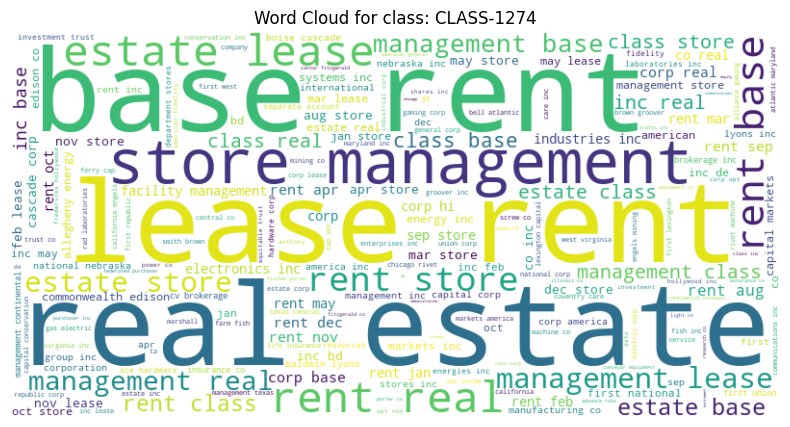

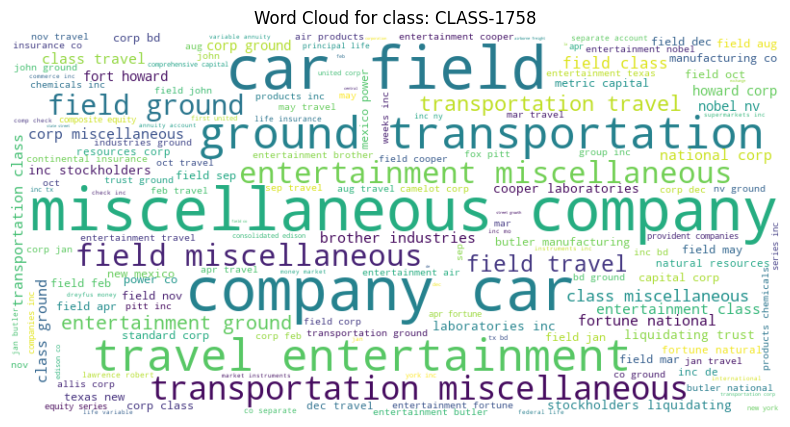

In [28]:
for cls in major_classes:
    tokens = get_tokens_for_class(df, cls)
    text_str = " ".join(tokens)

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate(text_str)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for class: {cls}")
    plt.show()

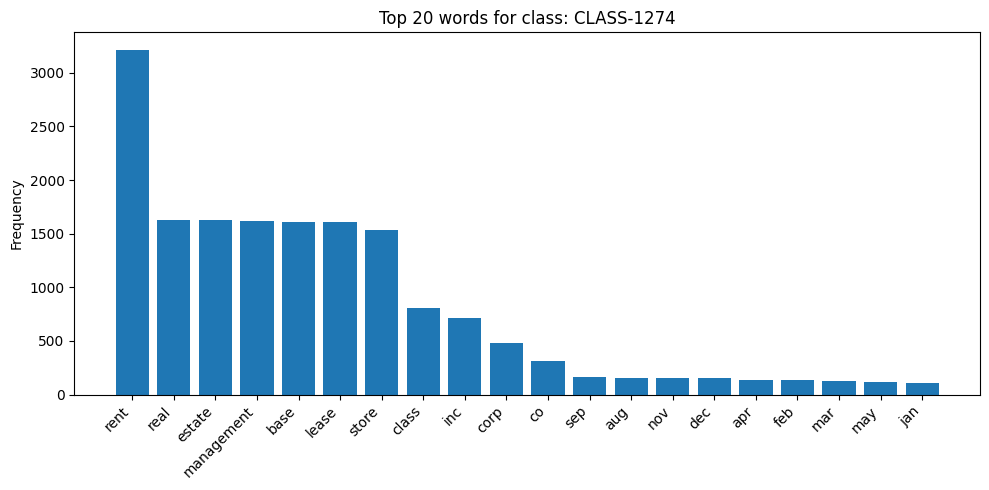

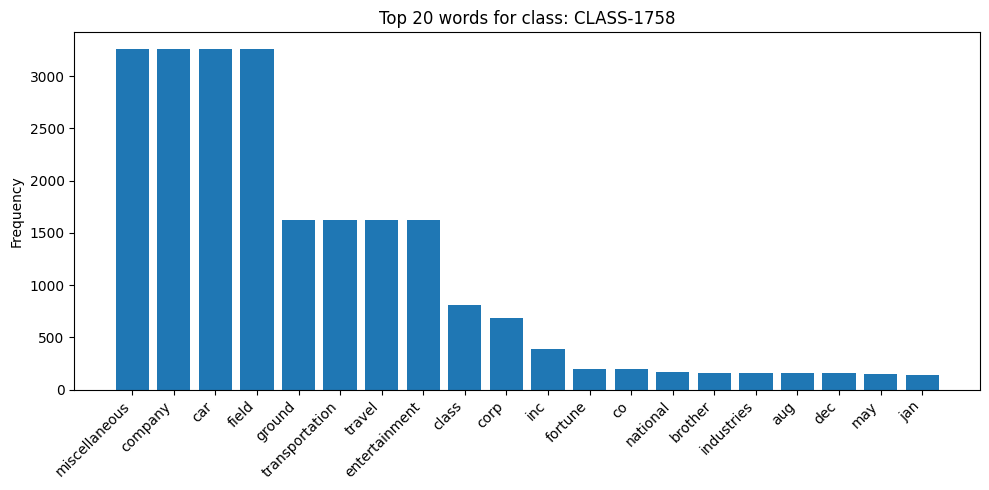

In [29]:
def plot_top_words(tokens, cls, top_n=20):
    counter = Counter(tokens)
    most_common = counter.most_common(top_n)
    words, counts = zip(*most_common)

    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Top {top_n} words for class: {cls}")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

for cls in major_classes:
    tokens = get_tokens_for_class(df, cls)
    plot_top_words(tokens, cls, top_n=20)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

BASE_PATH = r"C:\Users\Impana\Downloads\invoice-classification\\"
SROIE_PATH = os.path.join(BASE_PATH, "data", "sroie")

# Adjust file names if yours differ
pre_path  = os.path.join(SROIE_PATH, "D3_sroie_train.csv")        # enriched, before WordNet
post_path = os.path.join(SROIE_PATH, "D3_sroie_WNtrain10k.csv")   # enriched + WordNet ~10k

df_pre  = pd.read_csv(pre_path)
df_post = pd.read_csv(post_path)

print(df_pre["category"].value_counts())
print(df_post["category"].value_counts())

category
OTHER          498
RETAIL          78
FOOD            72
HARDWARE        50
STATIONERY      48
SERVICES         6
ELECTRONICS      6
HOTEL            4
Name: count, dtype: int64
category
OTHER          6497
RETAIL         1033
FOOD            936
STATIONERY      670
HARDWARE        661
ELECTRONICS      84
SERVICES         76
HOTEL            43
Name: count, dtype: int64


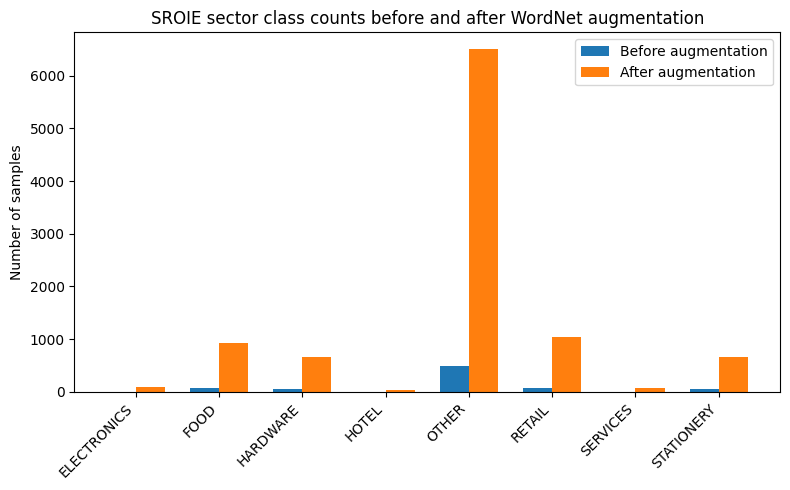

In [2]:
# Bar chart: class counts before vs after augmentation
pre_counts  = df_pre["category"].value_counts().sort_index()
post_counts = df_post["category"].value_counts().sort_index()

classes = pre_counts.index.tolist()  # assumes same label set in both

x = range(len(classes))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar([i - width/2 for i in x], pre_counts[classes],  width=width, label="Before augmentation")
plt.bar([i + width/2 for i in x], post_counts[classes], width=width, label="After augmentation")

plt.xticks(x, classes, rotation=45, ha="right")
plt.ylabel("Number of samples")
plt.title("SROIE sector class counts before and after WordNet augmentation")
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
import os
import pandas as pd

BASE_PATH = r"C:\Users\Impana\Downloads\invoice-classification\\"
SROIE_PATH = os.path.join(BASE_PATH, "data", "sroie")

# Adjust filename/columns if needed
csv_path = os.path.join(SROIE_PATH, "D3_sroie_train.csv")
df = pd.read_csv(csv_path)

# Keep only the columns you care about
df = df[["text", "category"]]

# Show a few random examples overall
print("Random examples (any class):")
print(df.sample(5, random_state=42).to_string(index=False))

# Show a few per class (e.g., FOOD and STATIONERY)
for cls in ["FOOD", "HARDWARE", "RETAIL", "STATIONERY", "OTHER"]:
    subset = df[df["category"] == cls]
    if subset.empty:
        continue
    print(f"\nExamples for class: {cls}")
    print(subset.sample(min(3, len(subset)), random_state=42).to_string(index=False))

Random examples (any class):
        text category
         lot    OTHER
         lot    OTHER
         air    OTHER
 lot banting    OTHER
domino pizza    OTHER

Examples for class: FOOD
              text category
        university     FOOD
          air food     FOOD
level th uptown ss     FOOD

Examples for class: HARDWARE
         text category
         shah HARDWARE
shah hardware HARDWARE
 air hardware HARDWARE

Examples for class: RETAIL
        text category
lot berkeley   RETAIL
         lot   RETAIL
lot berkeley   RETAIL

Examples for class: STATIONERY
                       text   category
    tun malaysia stationery STATIONERY
unit terrace lot stationery STATIONERY
            shah stationery STATIONERY

Examples for class: OTHER
   text category
    air    OTHER
pt shah    OTHER
    lot    OTHER


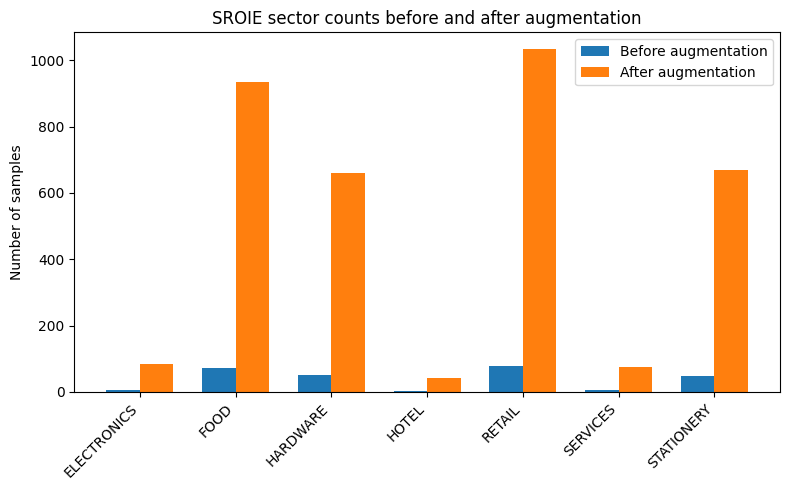

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

BASE_PATH = r"C:\Users\Impana\Downloads\invoice-classification\\"
SROIE_PATH = os.path.join(BASE_PATH, "data", "sroie")

pre_path  = os.path.join(SROIE_PATH, "D3_sroie_train.csv")
post_path = os.path.join(SROIE_PATH, "D3_sroie_WNtrain10k.csv")

df_pre  = pd.read_csv(pre_path)
df_post = pd.read_csv(post_path)

# Filter out OTHER
df_pre_no_other  = df_pre[df_pre["category"] != "OTHER"]
df_post_no_other = df_post[df_post["category"] != "OTHER"]

pre_counts  = df_pre_no_other["category"].value_counts().sort_index()
post_counts = df_post_no_other["category"].value_counts().sort_index()

classes = pre_counts.index.tolist()  # remaining labels without OTHER

x = range(len(classes))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar([i - width/2 for i in x], pre_counts[classes],
        width=width, label="Before augmentation")
plt.bar([i + width/2 for i in x], post_counts[classes],
        width=width, label="After augmentation")

plt.xticks(x, classes, rotation=45, ha="right")
plt.ylabel("Number of samples")
plt.title("SROIE sector counts before and after augmentation")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
import os
import pandas as pd

BASE_PATH = r"C:\Users\Impana\Downloads\invoice-classification\\"
d3_path = os.path.join(BASE_PATH, "data", "D3train.csv")

d3 = pd.read_csv(d3_path)
print(d3.columns)
d3.head()

Index(['description', 'label'], dtype='object')


,description,label
0,first union corp base rent oct lease rent real...,CLASS-1274
1,lease rent real estate may cv brokerage inc st...,CLASS-1274
2,workmen insurance corporate services three dep...,CLASS-2241
3,base rent store management acme electric corp ...,CLASS-1274
4,miscellaneous company car field ground transpo...,CLASS-1758


In [ ]:
# Example to pull the first few rows from D3train
sample = d3.head(4)[["description", "label", "description_enriched"]]  # use your actual enriched column name
print(sample)

KeyError: "['description_enriched'] not in index"

Table X: Examples of semantic enrichment on the Kaggle invoice dataset.

| Original description (cleaned)                                      | Label       | Enriched description                                      |
|---------------------------------------------------------------------|-------------|-----------------------------------------------------------|
| first union corp base rent oct lease rent real estate ...           | CLASS-1274  | first union corp base rent oct lease rent real estate ... <label token / sector cue> |
| lease rent real estate may cv brokerage inc store management ...    | CLASS-1274  | lease rent real estate may cv brokerage inc store management ... <label token / sector cue> |
| workmen insurance corporate services three department ...           | CLASS-2241  | workmen insurance corporate services three department ... <label token / sector cue> |
| miscellaneous company car field ground transport ...                | CLASS-1758  | miscellaneous company car field ground transport ... <label token / sector cue> |

In [8]:
import pandas as pd

# Fill with YOUR numbers
results = [
    # Kaggle invoice dataset (semantic enrich + WN 100k)
    {"Set": "KAGGLE", "Dataset": "Invoice_WN100k",
     "LSVM_acc": 1.00, "BiLSTM_acc": 1.00, "BERT_acc": 1.00,
     "LSVM_f1": 1.00, "BiLSTM_f1": 1.00, "BERT_f1": 1.00},

    # SROIE – LSVM baseline (your ~0.82 / 0.66)
    {"Set": "SROIE", "Dataset": "SROIE_WN10k",
     "LSVM_acc": 0.82, "BiLSTM_acc": 0.81, "BERT_acc": None,
     "LSVM_f1": 0.66, "BiLSTM_f1": 0.63, "BERT_f1": None},

    # SROIE – Bi‑LSTM with class weights (~0.65 / 0.58)
    {"Set": "SROIE", "Dataset": "SROIE_WN10k_clsW",
     "LSVM_acc": None, "BiLSTM_acc": 0.65, "BERT_acc": None,
     "LSVM_f1": None, "BiLSTM_f1": 0.58, "BERT_f1": None},
]

df = pd.DataFrame(results)
df

,Set,Dataset,LSVM_acc,BiLSTM_acc,BERT_acc,LSVM_f1,BiLSTM_f1,BERT_f1
0,KAGGLE,Invoice_WN100k,1.00,1.00,1.0,1.00,1.00,1.0
1,SROIE,SROIE_WN10k,0.82,0.81,NaN,0.66,0.63,NaN
2,SROIE,SROIE_WN10k_clsW,NaN,0.65,NaN,NaN,0.58,NaN


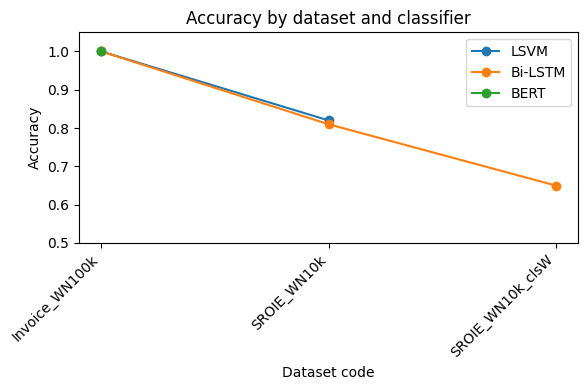

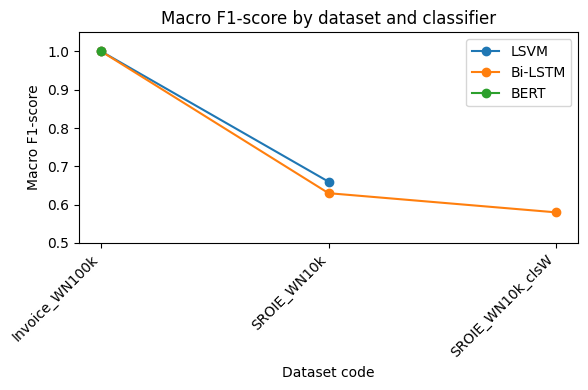

In [9]:
import matplotlib.pyplot as plt

# Sort by Dataset for consistent x‑axis
df_sorted = df.sort_values("Dataset")

x = df_sorted["Dataset"]

plt.figure(figsize=(6, 4))
plt.plot(x, df_sorted["LSVM_acc"],   marker="o", label="LSVM")
plt.plot(x, df_sorted["BiLSTM_acc"], marker="o", label="Bi-LSTM")
plt.plot(x, df_sorted["BERT_acc"],   marker="o", label="BERT")
plt.ylabel("Accuracy")
plt.xlabel("Dataset code")
plt.ylim(0.5, 1.05)
plt.title("Accuracy by dataset and classifier")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(x, df_sorted["LSVM_f1"],   marker="o", label="LSVM")
plt.plot(x, df_sorted["BiLSTM_f1"], marker="o", label="Bi-LSTM")
plt.plot(x, df_sorted["BERT_f1"],   marker="o", label="BERT")
plt.ylabel("Macro F1-score")
plt.xlabel("Dataset code")
plt.ylim(0.5, 1.05)
plt.title("Macro F1-score by dataset and classifier")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

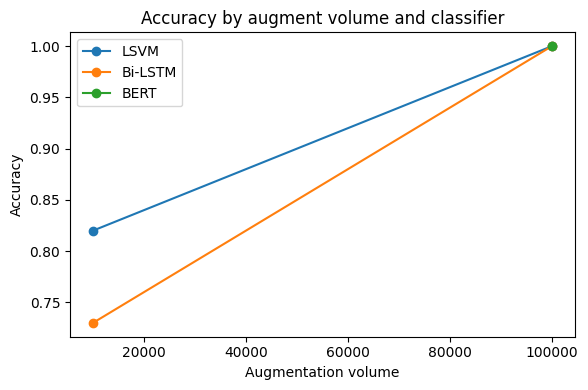

In [10]:
# Example extension: add augmentation volume (0, 100k, 10k, etc.)
df["augment_volume"] = [100000, 10000, 10000]  # replace with your real values

volumes = sorted(df["augment_volume"].unique())

acc_lsvm  = [df[df["augment_volume"] == v]["LSVM_acc"].mean() for v in volumes]
acc_bilstm = [df[df["augment_volume"] == v]["BiLSTM_acc"].mean() for v in volumes]
acc_bert   = [df[df["augment_volume"] == v]["BERT_acc"].mean() for v in volumes]

plt.figure(figsize=(6, 4))
plt.plot(volumes, acc_lsvm,  marker="o", label="LSVM")
plt.plot(volumes, acc_bilstm, marker="o", label="Bi-LSTM")
plt.plot(volumes, acc_bert,   marker="o", label="BERT")
plt.xlabel("Augmentation volume")
plt.ylabel("Accuracy")
plt.title("Accuracy by augment volume and classifier")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# 1. Get predictions
y_pred = lsvm.predict(X_test)

# 2. Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 3. Plot nicely
labels = le.classes_   # class names in order of encoder indices

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)

ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    ylabel="True label",
    xlabel="Predicted label",
    title="Confusion matrix – LSVM on Kaggle test set"
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Print counts on each cell
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=6
        )

fig.tight_layout()
plt.show()

NameError: name 'lsvm' is not defined

In [2]:
import os
import pandas as pd

BASE_PATH = r"C:\Users\Impana\Downloads\invoice-classification\\"
DATA_PATH = os.path.join(BASE_PATH, "data")

# Clean + enriched Kaggle sets (adjust names if different)
kaggle_train_path = os.path.join(DATA_PATH, "D3_WNtrain100k.csv")
kaggle_test_path  = os.path.join(DATA_PATH, "D2test.csv")

kaggle_train = pd.read_csv(kaggle_train_path)
kaggle_test  = pd.read_csv(kaggle_test_path)

print("=== Kaggle train (D3_WNtrain100k) ===")
print("Shape:", kaggle_train.shape)
print(kaggle_train.head(5))

print("\nColumn types:")
print(kaggle_train.dtypes)

print("\nLabel distribution (top 10):")
print(kaggle_train["label"].value_counts().head(10))

=== Kaggle train (D3_WNtrain100k) ===
Shape: (100000, 2)
                                         description       label
0  first union corp base rent oct lease rent real...  CLASS-1274
1  lease rent real estate may cv brokerage inc st...  CLASS-1274
2  workmen insurance corporate services three dep...  CLASS-2241
3  base rent store management acme electric corp ...  CLASS-1274
4  miscellaneous company car field ground transpo...  CLASS-1758

Column types:
description    object
label          object
dtype: object

Label distribution (top 10):
label
CLASS-1274    21705
CLASS-1758    21668
CLASS-1522    15874
CLASS-1376     7822
CLASS-1963     4446
CLASS-1250     4039
CLASS-1249     2638
CLASS-1828     2508
CLASS-2141     2397
CLASS-1721     2240
Name: count, dtype: int64


In [3]:
SROIE_PATH = os.path.join(DATA_PATH, "sroie")

sroie_train_path = os.path.join(SROIE_PATH, "D3_sroie_WNtrain10k.csv")
sroie_test_path  = os.path.join(SROIE_PATH, "D2_sroie_test.csv")

sroie_train = pd.read_csv(sroie_train_path)
sroie_test  = pd.read_csv(sroie_test_path)

print("\n=== SROIE train (D3_sroie_WNtrain10k) ===")
print("Shape:", sroie_train.shape)
print(sroie_train.head(5))

print("\nColumn types:")
print(sroie_train.dtypes)

print("\nSector distribution:")
print(sroie_train["category"].value_counts())


=== SROIE train (D3_sroie_WNtrain10k) ===
Shape: (10000, 2)
                        text category
0                        jay    OTHER
1  unit vivacity wan sarawak    OTHER
2         level th uptown ss     FOOD
3         level th uptown ss     FOOD
4                       shah    OTHER

Column types:
text        object
category    object
dtype: object

Sector distribution:
category
OTHER          6497
RETAIL         1033
FOOD            936
STATIONERY      670
HARDWARE        661
ELECTRONICS      84
SERVICES         76
HOTEL            43
Name: count, dtype: int64


In [2]:
import pandas as pd

data = [
    {"Model": "LSVM",
     "Data variant": "Cleaned + enriched (D3train)",
     "Accuracy": "1.00",
     "Macro-F1": "1.00"},
    {"Model": "LSVM",
     "Data variant": "Cleaned + enriched + WN-aug",
     "Accuracy": "1.00",
     "Macro-F1": "1.00"},
    {"Model": "Bi-LSTM",
     "Data variant": "Cleaned + enriched (D3train)",
     "Accuracy": "1.00",
     "Macro-F1": "1.00"},
    {"Model": "BERT",
     "Data variant": "Cleaned + enriched (D3train)",
     "Accuracy": "1.00",
     "Macro-F1": "1.00"},
]

df_results = pd.DataFrame(data)
df_results

,Model,Data variant,Accuracy,Macro-F1
0,LSVM,Cleaned + enriched (D3train),1.00,1.00
1,LSVM,Cleaned + enriched + WN-aug,1.00,1.00
2,Bi-LSTM,Cleaned + enriched (D3train),1.00,1.00
3,BERT,Cleaned + enriched (D3train),1.00,1.00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# True labels
y_true = y_test  # encoded ints

# Predictions from your three models
y_pred_lsvm   = y_pred_lsvm   # LSVM predictions
y_pred_bilstm = y_pred_bilstm # Bi-LSTM predictions
y_pred_bert   = y_pred_bert   # BERT predictions

models = ["LSVM", "Bi-LSTM", "BERT"]

accs = [
    accuracy_score(y_true, y_pred_lsvm),
    accuracy_score(y_true, y_pred_bilstm),
    accuracy_score(y_true, y_pred_bert),
]

macro_f1s = [
    f1_score(y_true, y_pred_lsvm, average="macro"),
    f1_score(y_true, y_pred_bilstm, average="macro"),
    f1_score(y_true, y_pred_bert, average="macro"),
]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, accs,      width=width, label="Accuracy")
plt.bar(x + width/2, macro_f1s, width=width, label="Macro F1")

plt.xticks(x, models)
plt.ylim(0.8, 1.05)
plt.ylabel("Score")
plt.title("Kaggle – Accuracy and Macro-F1 by model")
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'y_test' is not defined

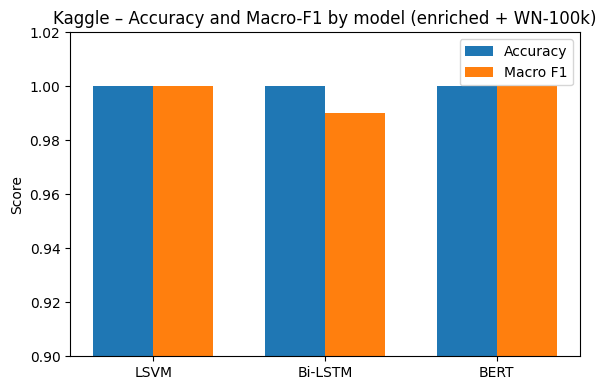

In [4]:
import numpy as np
import matplotlib.pyplot as plt

models = ["LSVM", "Bi-LSTM", "BERT"]

# From your reports: all essentially perfect
accs =  [1.00, 1.00, 1.00]
macro_f1s = [1.00, 0.99, 1.00]  # Bi-LSTM macro-F1 ≈ 0.99, others ≈ 1.00

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, accs,      width=width, label="Accuracy")
plt.bar(x + width/2, macro_f1s, width=width, label="Macro F1")

plt.xticks(x, models)
plt.ylim(0.9, 1.02)
plt.ylabel("Score")
plt.title("Kaggle – Accuracy and Macro-F1 by model (enriched + WN-100k)")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd

data = [
    {
        "Model": "LSVM (enriched + WN train)",
        "Accuracy": 0.82,
        "Macro-F1": 0.66,
        "Weighted F1": 0.80,
    },
    {
        "Model": "Bi-LSTM (no class weights)",
        "Accuracy": 0.81,
        "Macro-F1": 0.63,
        "Weighted F1": 0.78,
    },
    {
        "Model": "Bi-LSTM (with class weights)",
        "Accuracy": 0.65,
        "Macro-F1": 0.58,
        "Weighted F1": 0.66,
    },
]

df_sroie = pd.DataFrame(data)
df_sroie

,Model,Accuracy,Macro-F1,Weighted F1
0,LSVM (enriched + WN train),0.82,0.66,0.80
1,Bi-LSTM (no class weights),0.81,0.63,0.78
2,Bi-LSTM (with class weights),0.65,0.58,0.66


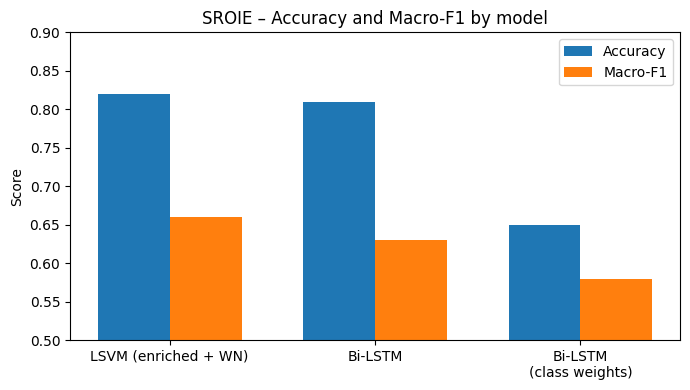

In [6]:
import numpy as np
import matplotlib.pyplot as plt

models = [
    "LSVM (enriched + WN)",
    "Bi-LSTM",
    "Bi-LSTM\n(class weights)",
]

accuracy = [0.82, 0.81, 0.65]
macro_f1  = [0.66, 0.63, 0.58]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(7, 4))
plt.bar(x - width/2, accuracy, width=width, label="Accuracy")
plt.bar(x + width/2, macro_f1, width=width, label="Macro-F1")

plt.xticks(x, models, rotation=0, ha="center")
plt.ylim(0.5, 0.9)
plt.ylabel("Score")
plt.title("SROIE – Accuracy and Macro-F1 by model")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd

# Table C1 – paper ERP vs Kaggle (LSVM)
data_c1 = [
    {
        "Dataset": "Paper ERP (post-clean, pre-aug)",
        "Best LSVM accuracy": "84.4%",
        "Best LSVM macro-F1": "75%",
    },
    {
        "Dataset": "Paper ERP (post-enrich, pre-aug)",
        "Best LSVM accuracy": "84–86%",
        "Best LSVM macro-F1": "76%",
    },
    {
        "Dataset": "Kaggle (clean + enrich)",
        "Best LSVM accuracy": "≈100%",
        "Best LSVM macro-F1": "≈100%",
    },
]

df_c1 = pd.DataFrame(data_c1)
df_c1  # will render as a table in Jupyter / VS Code


,Dataset,Best LSVM accuracy,Best LSVM macro-F1
0,"Paper ERP (post-clean, pre-aug)",84.4%,75%
1,"Paper ERP (post-enrich, pre-aug)",84–86%,76%
2,Kaggle (clean + enrich),≈100%,≈100%


In [15]:
# Table C2 – paper ERP vs SROIE (macro-F1)
data_c2 = [
    {
        "Setting": "Paper ERP – clean only",
        "Accuracy range": "83–84%",
        "Macro-F1 range": "up to ~75%",
        "Best model": "LSVM",
    },
    {
        "Setting": "Paper ERP – enrich + aug",
        "Accuracy range": "84–88%",
        "Macro-F1 range": "up to ~81%",
        "Best model": "BERT + WordNet",
    },
    {
        "Setting": "SROIE – enrich + WN aug",
        "Accuracy range": "65–82%",
        "Macro-F1 range": "0.58–0.66",
        "Best model": "LSVM (overall)",
    },
]

df_c2 = pd.DataFrame(data_c2)
df_c2


,Setting,Accuracy range,Macro-F1 range,Best model
0,Paper ERP – clean only,83–84%,up to ~75%,LSVM
1,Paper ERP – enrich + aug,84–88%,up to ~81%,BERT + WordNet
2,SROIE – enrich + WN aug,65–82%,0.58–0.66,LSVM (overall)


In [9]:
pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Note: you may need to restart the kernel to use updated packages.
